### Загрузка библиотек

In [858]:
import numpy as np
import pandas as pd
import random
import pickle

In [859]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import r2_score as r2, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV

In [860]:
from datetime import datetime

In [861]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [862]:
import warnings
warnings.filterwarnings('ignore')

In [863]:
matplotlib.rcParams.update({'font.size': 14})

### Загрузка данных

In [864]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [865]:

train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)
print(f"Train dataset containes\t{train_df.shape[0]}\t objects and {train_df.shape[1]} features")
print(f"Test dataset containes\t{test_df.shape[0]}\t objects and {test_df.shape[1]} features")

Train dataset containes	10000	 objects and 20 features
Test dataset containes	5000	 objects and 19 features


#### Уменьшение объма данных

In [866]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


In [867]:
reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.35 MB
Decreased by 76.8%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.96875,29.437500,6.0,7,9.0,1969,0.089050,B,B,33,7976,5,NaN,0,11,B,184966.937500
1,15053,41,3.0,65.68750,40.062500,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
2,4765,53,2.0,44.93750,29.203125,0.0,8,12.0,1968,0.049652,B,B,34,7759,0,229.0,1,3,B,220925.906250
3,5809,58,2.0,53.34375,52.718750,9.0,8,17.0,1977,0.437988,B,B,23,5735,3,1084.0,0,5,B,175616.234375
4,10783,99,1.0,39.65625,23.781250,7.0,11,12.0,1976,0.012337,B,B,35,5776,1,2078.0,2,4,B,150226.531250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.40625,30.468750,5.0,6,5.0,1968,0.135620,B,B,46,7960,6,350.0,3,11,B,196684.312500
9996,6159,18,1.0,41.53125,20.546875,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.296875
9997,5123,27,1.0,47.93750,NaN,1.0,12,16.0,2015,0.072144,B,B,2,629,1,NaN,0,0,A,159143.812500
9998,5400,75,2.0,43.59375,33.843750,8.0,1,5.0,1961,0.307373,B,A,30,5048,9,325.0,2,5,B,181595.343750


In [868]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float16 
 3   Square         10000 non-null  float16 
 4   LifeSquare     7887 non-null   float16 
 5   KitchenSquare  10000 non-null  float16 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float16 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float16 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float16 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

### Описание датасета

**Id** - идентификационный номер квартиры

**DistrictID** - идентификационный номер района

**Rooms** - количество комнат

**Square** - площадь

**LifeSquare** - жилая площадь

**KitchenSquare** - площадь кухни

**Floor** - этаж

**HouseFloor** - количество этажей в доме

**HouseYear** - год постройки дома

**Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности

**Social_1, Social_2, Social_3** - социальные показатели местности

**Healthcare_1, Helthcare_2** - показатели местности, связанные с ораной здоровья

**Shops_1, Shops_2** - показатели, связанные с наичием магазинов, торговых центров

**Price** - цена квартиры

array([[<AxesSubplot:title={'center':'Id'}>,
        <AxesSubplot:title={'center':'DistrictId'}>,
        <AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>],
       [<AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>,
        <AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>],
       [<AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>,
        <AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>],
       [<AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>,
        <AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>],
       [<AxesSubplot:title={'center':'Price'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

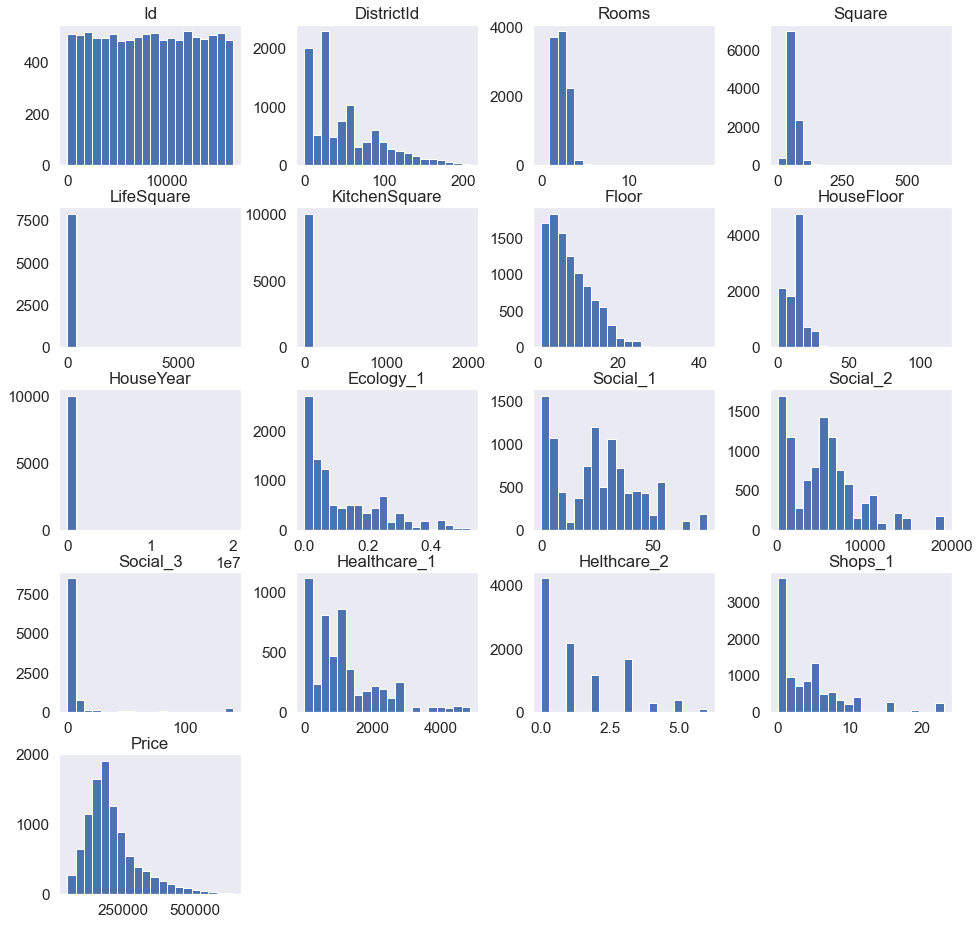

In [869]:
train_df.hist(figsize=(16,16), bins = 20, grid = False)

### Приведение типов

In [870]:
train_df.dtypes

Id                  int16
DistrictId          int16
Rooms             float16
Square            float16
LifeSquare        float16
KitchenSquare     float16
Floor                int8
HouseFloor        float16
HouseYear           int32
Ecology_1         float16
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float16
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [871]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### EDA

In [872]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,1.000000e+04,7887.000000,1.000000e+04,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.0,10000.000000,10000.000000,10000.000000
mean,1.891602,inf,inf,6.273438e+00,8.526700,inf,3.990166e+03,0.118896,24.687000,5352.157400,8.039200,inf,1.319500,4.231300,214139.218750
std,0.839844,inf,inf,inf,5.241148,6.777344e+00,2.005003e+05,0.119019,17.532614,4006.799803,23.831875,inf,1.493601,4.806341,92872.304688
min,0.000000,1.136719e+00,0.370605,0.000000e+00,1.000000,0.000000e+00,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.0,0.000000,0.000000,59174.777344
25%,1.000000,4.178125e+01,22.765625,1.000000e+00,4.000000,9.000000e+00,1.974000e+03,0.017654,6.000000,1564.000000,0.000000,350.0,0.000000,1.000000,153872.628906
50%,2.000000,5.250000e+01,32.781250,6.000000e+00,7.000000,1.300000e+01,1.977000e+03,0.075439,25.000000,5285.000000,2.000000,900.0,1.000000,3.000000,192269.648438
75%,2.000000,6.587500e+01,45.125000,9.000000e+00,12.000000,1.700000e+01,2.001000e+03,0.195801,36.000000,7227.000000,5.000000,1548.0,2.000000,6.000000,249135.460938
max,19.000000,6.410000e+02,7480.000000,2.014000e+03,42.000000,1.170000e+02,2.005201e+07,0.521973,74.000000,19083.000000,141.000000,4848.0,6.000000,23.000000,633233.437500


#### Целевая переменная - Price

In [873]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]

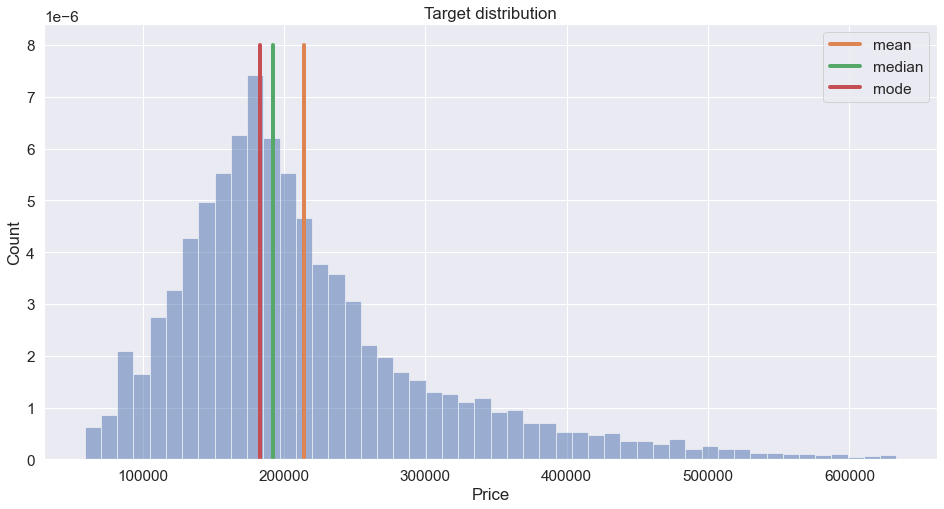

In [874]:
plt.figure(figsize= (16, 8))

plt.hist(train_df['Price'], density = True, bins = 50, alpha = 0.5)
plt.ylabel('Count')
plt.xlabel('Price')
y = np.linspace(0, 0.000008, 10)
plt.plot([target_mean] * 10, y, label = 'mean', linewidth = 4)
plt.plot([target_median] * 10, y, label = 'median', linewidth = 4)
plt.plot([target_mode] * 10, y, label = 'mode', linewidth = 4)
plt.legend()
plt.title('Target distribution')
plt.show()

### Обработка выбросов и пропусков

##### Rooms

In [875]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [876]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [877]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

##### Square

In [878]:
square_mean = round(train_df['Square'].mean(), 2)
square_median = train_df['Square'].median()
square_mode = train_df['Square'].mode()[0]

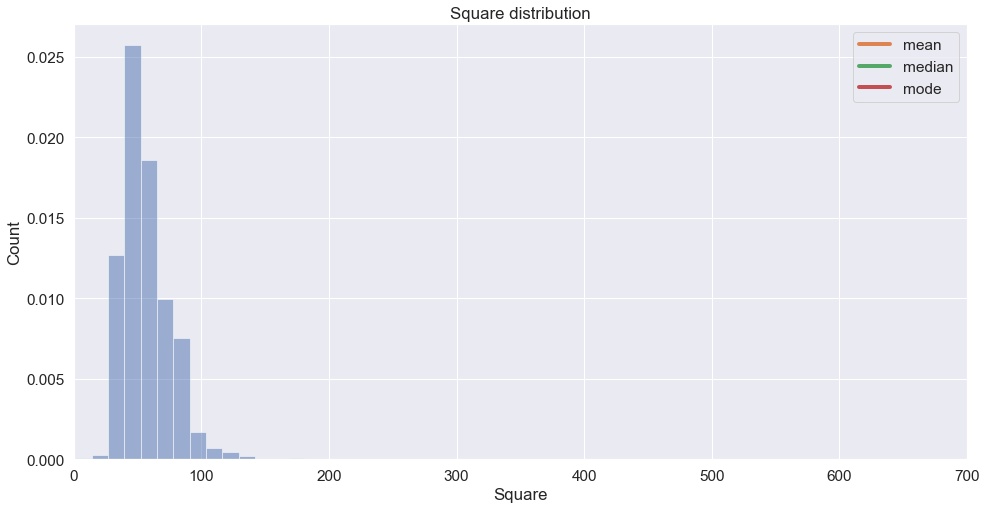

In [879]:
plt.figure(figsize= (16, 8))

plt.hist(train_df['Square'], density = True, bins = 50, alpha = 0.5)
plt.ylabel('Count')
plt.xlabel('Square')
y = np.linspace(0, 0.000005, 30)
plt.xlim(0,700)
plt.plot([square_mean]*30, y, label = 'mean', linewidth = 4)
plt.plot([square_median]*30, y, label = 'median', linewidth = 4)
plt.plot([square_mode]*30, y, label = 'mode', linewidth = 4)
plt.legend()
plt.title('Square distribution')
plt.show()

In [880]:
train_df.loc[train_df['Square'] > 400, 'Square'] = train_df['Square'].median()

##### LifeSquare

In [881]:
train_df.loc[train_df['Square'] < train_df['LifeSquare'],
           'LifeSquare'] = train_df['Square']

In [882]:
condition = (train_df['LifeSquare'].isna()) & (~train_df['Square'].isna()) & (~train_df['KitchenSquare'].isna())
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] - train_df.loc[condition, 'KitchenSquare']

##### KitchenSquare

In [883]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
32.0         2
41.0         2
51.0         2
30.0         2
112.0        2
37.0         2
43.0         2
25.0         2
58.0         2
84.0         1
75.0         1
21.0         1
54.0         1
62.0         1
40.0         1
29.0         1
1970.0       1
27.0         1
39.0         1
35.0         1
23.0         1
73.0         1
31.0         1
60.0         1
63.0         1
42.0         1
36.0         1
96.0         1
26.0         1
53.0         1
78.0         1
66.0         1
2014.0       1
48.0         1
72.0         1
123.0        1
Name: KitchenSquare, dtype: int64

<AxesSubplot:xlabel='KitchenSquare'>

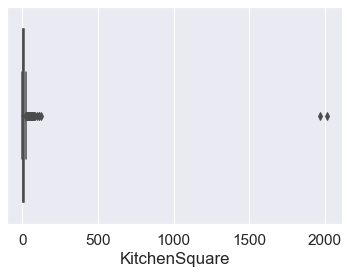

In [884]:
sns.boxplot(train_df.KitchenSquare)

In [885]:
train_df['KitchenSquare'].describe()

count    1.000000e+04
mean     6.273438e+00
std               inf
min      0.000000e+00
25%      1.000000e+00
50%      6.000000e+00
75%      9.000000e+00
max      2.014000e+03
Name: KitchenSquare, dtype: float64

In [886]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [887]:
condition = (train_df['KitchenSquare'].isna()) | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))

train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [888]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

##### HouseFloor, Floor

In [889]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float16)

In [890]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [891]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [892]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor']

7       0.0
23      0.0
26      0.0
39      0.0
44      0.0
       ... 
9707    0.0
9769    0.0
9878    0.0
9908    0.0
9944    0.0
Name: HouseFloor, Length: 269, dtype: float16

In [893]:
train_df.loc[train_df['HouseFloor'] == 99, 'HouseFloor']

6131    99.0
8599    99.0
Name: HouseFloor, dtype: float16

In [894]:
train_df.loc[train_df['HouseFloor'] == 117, 'HouseFloor']

8854    117.0
Name: HouseFloor, dtype: float16

In [895]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] ==0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [896]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [897]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([   7,   14,   16,   21,   26,   35,   39,   44,   51,   67,
            ...
            9959, 9962, 9971, 9973, 9975, 9984, 9985, 9989, 9991, 9995],
           dtype='int64', length=1610)

In [898]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1,x))

In [899]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

##### HouseYear

In [900]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
5701        2020
2493        2020
1499        2020
          ...   
7611        1916
910         1914
2656        1912
5111        1912
9317        1910
Name: HouseYear, Length: 10000, dtype: int32

In [901]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

##### Healthcare_1

In [902]:
train_df.drop('Healthcare_1', axis = 1, inplace=True)

##### Ecology_2, Ecology_3, Shops_2

In [903]:
binary_to_numbers = {'A': 0, 'B':1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

### Класс для обработки данных

In [904]:
class DataPreprocessing:
    """Подготовка исходных данных"""
    
    def __init__ (self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
    
    def fit (self, X):
        """Сохранение статистик"""
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        binary_to_numbers = {'A': 0, 'B':1}
        
    def transform (self, X):
        """Трансформация данных"""
        
#         Приведение типов
        
        X['Id'] = X['Id'].astype(str)
        X['DistrictId'] = X['DistrictId'].astype(str)
        
#         Rooms
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
#         Square
        X.loc[X['Square'] > 400, 'Square'] = self.medians['Square']
    
#         LifeSquare
        X.loc[X['Square'] < X['LifeSquare'], 'LifeSquare'] = X['Square']
        condition = (X['LifeSquare'].isna()) & (~X['Square'].isna()) & (~X['KitchenSquare'].isna())
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare']
        
#         KitchenSquare
        condition = (X['KitchenSquare'].isna()) | (X['KitchenSquare'] > self.kitchen_square_quantile)

        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
#         HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1,x))
    
#         HouseYear
        X.loc[X['HouseYear'] > 2020, 'HouseYear'] = 2020
        
#         Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis = 1, inplace=True)

    
        X.fillna(self.medians, inplace = True)
        
#         Ecology_2, Ecology_3, Shops_2
        
        X['Ecology_2'] = X['Ecology_2'].replace(binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].replace(binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].replace(binary_to_numbers)
        
        return X

### Добавление новых признаков

##### DistrictSize, IsDistrictLarge

In [905]:
district_size = train_df['DistrictId'].value_counts().reset_index().rename(columns={'index': 'DistrictId','DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [906]:
train_df = train_df.merge(district_size, on = 'DistrictId', how = 'left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,HouseFloor_outlier,DistrictSize
0,14038,35,2.0,47.96875,29.437500,6.0,7,9.0,1969,0.089050,...,1,33,7976,5,0,11,1,184966.937500,0,22
1,15053,41,3.0,65.68750,40.062500,8.0,7,9.0,1978,0.000070,...,1,46,10309,1,1,16,1,300009.437500,0,87
2,4765,53,2.0,44.93750,29.203125,3.0,8,12.0,1968,0.049652,...,1,34,7759,0,1,3,1,220925.906250,0,174
3,5809,58,2.0,53.34375,52.718750,9.0,8,17.0,1977,0.437988,...,1,23,5735,3,0,5,1,175616.234375,0,179
4,10783,99,1.0,39.65625,23.781250,7.0,11,12.0,1976,0.012337,...,1,35,5776,1,2,4,1,150226.531250,0,97


In [907]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [908]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize']> 100).astype(int)

### Year and Floor category

In [909]:
def floor_to_cat(X):
    X['floor_cat'] = 0
    
    X.loc[X['Floor'] <=3, 'floor_cat'] = 1
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5
    
    return X

def year_to_cat(X):
    X['year_cat'] = 0
    
    X.loc[X['HouseYear'] <=1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[X['HouseYear'] > 2010, 'year_cat'] = 6
    
    return X

In [910]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,HouseFloor_outlier,DistrictSize,IsDistrictLarge,year_cat,floor_cat
0,14038,35,2.0,47.96875,29.437500,6.0,7,9.0,1969,0.089050,...,5,0,11,1,184966.937500,0,22,0,3,3
1,15053,41,3.0,65.68750,40.062500,8.0,7,9.0,1978,0.000070,...,1,1,16,1,300009.437500,0,87,0,3,3
2,4765,53,2.0,44.93750,29.203125,3.0,8,12.0,1968,0.049652,...,0,1,3,1,220925.906250,0,174,1,3,3
3,5809,58,2.0,53.34375,52.718750,9.0,8,17.0,1977,0.437988,...,3,0,5,1,175616.234375,0,179,1,3,3
4,10783,99,1.0,39.65625,23.781250,7.0,11,12.0,1976,0.012337,...,1,2,4,1,150226.531250,0,97,0,3,4


### WW2House

Text(0.5, 1.0, 'Distribution of Price by Year Category')

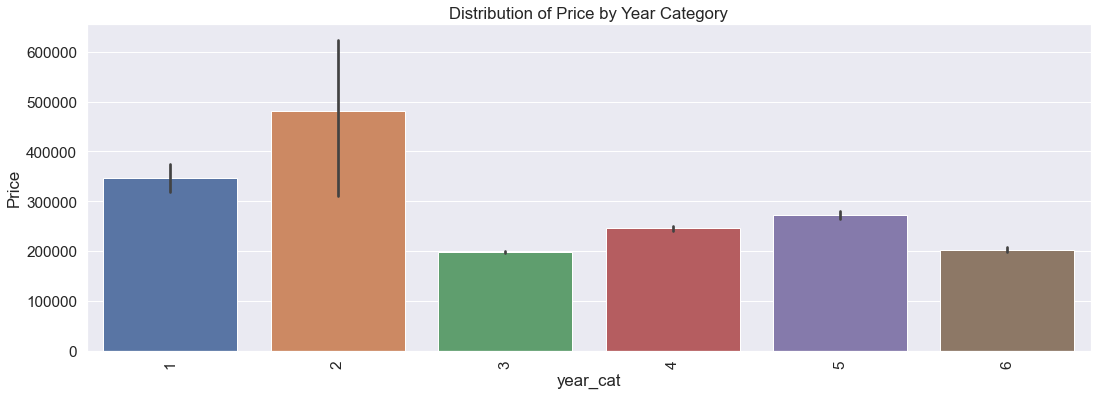

In [911]:
plt.figure(figsize=(18, 6))
sns.barplot(train_df['year_cat'], train_df['Price'])
plt.xticks(rotation=90)
plt.title('Distribution of Price by Year Category')

In [912]:
def WW2House_binary(X):
    X['WW2House_binary'] = 0
    X.loc[X['HouseYear'] <=1945, 'WW2House_binary'] = 1
    
    return X

In [913]:
train_df = WW2House_binary(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,HouseFloor_outlier,DistrictSize,IsDistrictLarge,year_cat,floor_cat,WW2House_binary
0,14038,35,2.0,47.96875,29.437500,6.0,7,9.0,1969,0.089050,...,0,11,1,184966.937500,0,22,0,3,3,0
1,15053,41,3.0,65.68750,40.062500,8.0,7,9.0,1978,0.000070,...,1,16,1,300009.437500,0,87,0,3,3,0
2,4765,53,2.0,44.93750,29.203125,3.0,8,12.0,1968,0.049652,...,1,3,1,220925.906250,0,174,1,3,3,0
3,5809,58,2.0,53.34375,52.718750,9.0,8,17.0,1977,0.437988,...,0,5,1,175616.234375,0,179,1,3,3,0
4,10783,99,1.0,39.65625,23.781250,7.0,11,12.0,1976,0.012337,...,2,4,1,150226.531250,0,97,0,3,4,0


Text(0.5, 1.0, 'Distribution of Price deppending on WW2')

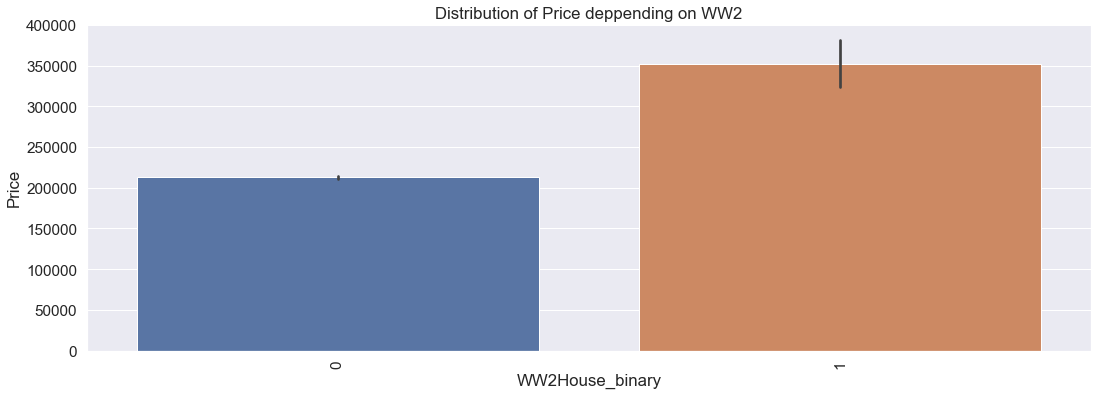

In [914]:
plt.figure(figsize=(18, 6))
sns.barplot(train_df['WW2House_binary'], train_df['Price'])
plt.xticks(rotation=90)
plt.title('Distribution of Price deppending on WW2')

### Класс создания признаков

In [915]:
class FeatureGenerator():
    """Создание новы фич"""
    
    def __init__(self):
        self.district_size = None
#         self.med_price_by_floor_year = None
#         self.med_price_by_floor_year_median = None
        
        
        
    def fit(self, X, y = None):
        X = X.copy()
        
#         DistrictSize
        self.district_size = X['DistrictId'].value_counts().reset_index().rename(columns={'index': 'DistrictId','DistrictId':'DistrictSize'})
        
#         df = X.copy()
        
#         MedPriceByFloorYear
#         if y is not None:
#             df['Price'] = y.values
            

#         self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price': 'median'}).rename(columns={'Price': 'MedPriceByFloorYear'})
#         self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
            
    
    def transform(self, X):
        
#         DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on = 'DistrictId', how = 'left')
        X['IsDistrictLarge'] = (X['DistrictSize']> 100).astype(int)
        
        
#         if self.med_price_by_floor_year is not None:
#             X = X.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how = 'left')
#             X.fillna(self.med_price_by_floor_year_median, inplace = True)


    
#     Floor category
        X['floor_cat'] = 0
    
        X.loc[X['Floor'] <=3, 'floor_cat'] = 1
        X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
        X['floor_cat'].fillna(-1, inplace = True)


#     Year category
        X['year_cat'] = 0
    
        X.loc[X['HouseYear'] <=1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[X['HouseYear'] > 2010, 'year_cat'] = 6
        X['year_cat'].fillna(-1, inplace = True)


#         WW2House

        X['WW2House_binary'] = 0
        X.loc[X['HouseYear'] <=1945, 'WW2House_binary'] = 1
    
        return X     
        

### Отбор признаков

In [916]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'HouseFloor_outlier',
 'DistrictSize',
 'IsDistrictLarge',
 'year_cat',
 'floor_cat',
 'WW2House_binary']

In [917]:
feature_names = ['Rooms','Square','LifeSquare','KitchenSquare','Floor','HouseFloor','HouseYear','Ecology_1','Ecology_2','Ecology_3','Social_1','Social_2','Social_3','Helthcare_2','Shops_1','Shops_2']

In [918]:
new_feature_names = ['HouseFloor_outlier','DistrictSize','IsDistrictLarge','year_cat','floor_cat','MedPriceByFloorYear','WW2House_binary']

In [919]:
target_name = 'Price'

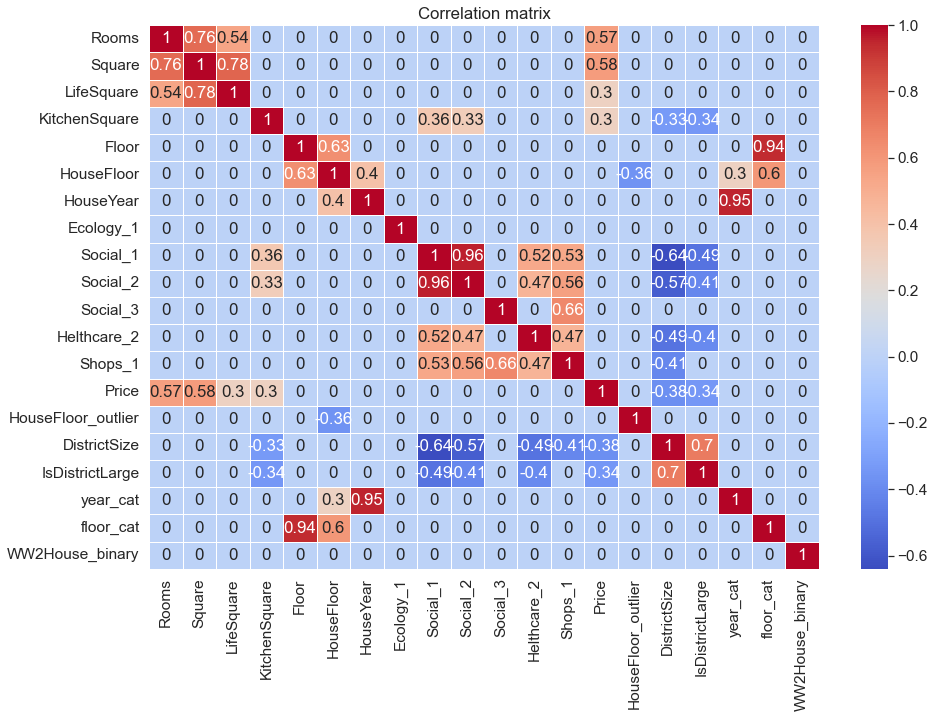

In [920]:
plt.figure(figsize=(15,10))
sns.set(font_scale = 1.4)
corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix)<0.3] = 0
sns.heatmap(corr_matrix, annot = True, linewidths=.5,cmap = 'coolwarm')
plt.title('Correlation matrix')
plt.show()

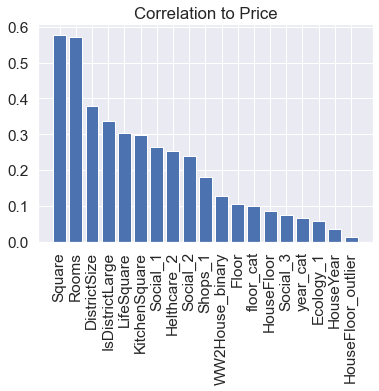

In [921]:
corrmat = train_df.loc[:, train_df.columns != 'Id'].corrwith(train_df['Price']).abs().sort_values(ascending=False)[1:]
plt.bar(corrmat.index, corrmat.values)
plt.title('Correlation to Price')
plt.xticks(rotation='vertical')
plt.show()

### Нормализация данных

In [922]:
train_df[feature_names].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Rooms          10000 non-null  float16 
 1   Square         10000 non-null  float16 
 2   LifeSquare     10000 non-null  float16 
 3   KitchenSquare  10000 non-null  float16 
 4   Floor          10000 non-null  int64   
 5   HouseFloor     10000 non-null  float16 
 6   HouseYear      10000 non-null  int32   
 7   Ecology_1      10000 non-null  float16 
 8   Ecology_2      10000 non-null  category
 9   Ecology_3      10000 non-null  category
 10  Social_1       10000 non-null  int8    
 11  Social_2       10000 non-null  int16   
 12  Social_3       10000 non-null  int16   
 13  Helthcare_2    10000 non-null  int8    
 14  Shops_1        10000 non-null  int8    
 15  Shops_2        10000 non-null  category
dtypes: category(3), float16(6), int16(2), int32(1), int64(1), int8(3)
memory usag

In [923]:
feature_names_for_stand = train_df.drop(columns=target_name).select_dtypes(include=['float32', 'float16', 'int64','int32']).columns.tolist()

In [924]:
scaler = RobustScaler()
stand_features =scaler.fit_transform(train_df[feature_names_for_stand])
stand_features

array([[ 0.        , -0.18806744, -0.3111685 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.54734112,  0.1278244 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.31387808, -0.32085216, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.        , -0.18936446,  0.41187863, ...,  1.5       ,
         0.33333333,  0.        ],
       [ 0.        , -0.36964981, -0.12911556, ...,  0.        ,
        -0.66666667,  0.        ],
       [-1.        , -0.57457847, -0.65332473, ...,  0.5       ,
         0.        ,  0.        ]])

In [925]:
train_df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

### Разбиение на обучающий и валидационный датасеты

In [926]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [927]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.33, shuffle=True, random_state=42)

In [928]:
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,HouseFloor_outlier,DistrictSize,IsDistrictLarge,year_cat,floor_cat,WW2House_binary
8371,819,61,1.0,0.468223,0.074887,0.4,0.000,-0.500,0.074074,1.262184,...,6,1,9,1,0.0,0.030702,0.0,0.0,0.000000,0.0
5027,3074,109,0.0,0.378729,-0.161394,0.6,0.500,0.125,0.111111,-0.423469,...,4,1,1,1,0.0,-0.138158,-1.0,0.0,0.333333,0.0
9234,7958,23,-1.0,-0.439689,0.162686,-0.6,0.000,0.500,0.000000,0.002056,...,3,0,2,1,0.0,1.010965,0.0,0.0,0.000000,0.0
3944,14351,113,-1.0,-0.430610,-0.602324,0.4,0.250,-0.125,0.259259,-0.082398,...,2,0,7,1,0.0,-0.138158,-1.0,0.5,0.000000,0.0
6862,4626,64,0.0,-0.290532,-0.182053,0.0,0.375,-0.500,-0.222222,0.337816,...,6,3,11,1,0.0,-0.166667,-1.0,0.0,0.000000,0.0


In [929]:
y_train.head()

8371    290331.406250
5027    412668.437500
9234    109451.984375
3944    246354.078125
6862    217344.453125
Name: Price, dtype: float32

#### Функция для оценки результата работы модели

In [930]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize = (18,10))
    
    plt.subplot(121)
    sns.scatterplot(x = train_pred_values, y = train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x = test_pred_values, y = test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    
    plt.show()

### Построение модели

Train R2:	0.911
Test R2:	0.724


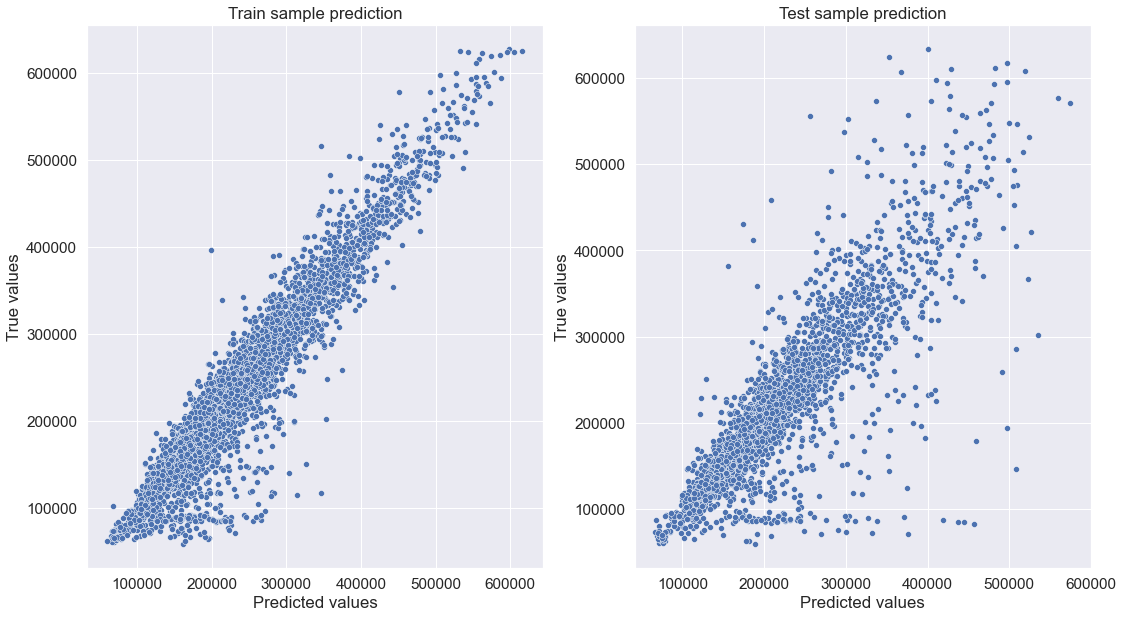

In [931]:
gb_model = GradientBoostingRegressor(criterion = 'mse', max_depth = 7, min_samples_leaf = 10, random_state = 42, n_estimators = 100)
gb_model.fit(X_train, y_train)
y_train_preds = gb_model.predict(X_train)
y_valid_preds = gb_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

#### Обучение и оценка модели послк подбора гиперпараметров

Train R2:	0.844
Test R2:	0.73


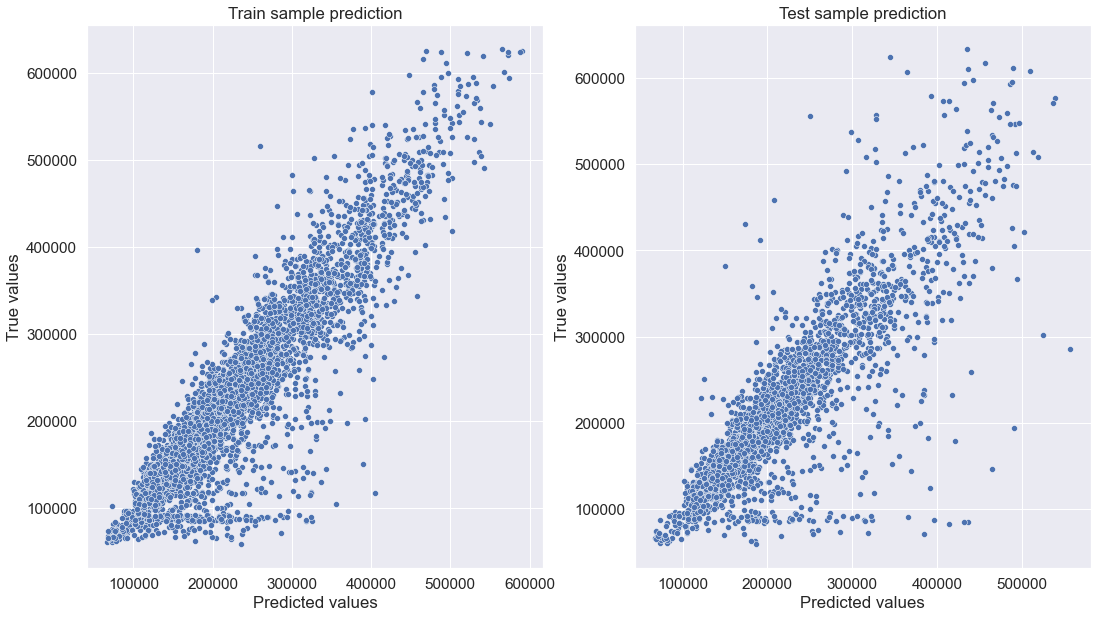

In [933]:
final_gb_model = GradientBoostingRegressor(criterion = 'mse', max_depth = 5, min_samples_leaf = 10, random_state = 42, n_estimators = 100)
final_gb_model.fit(X_train, y_train)
y_train_preds = final_gb_model.predict(X_train)
y_valid_preds = final_gb_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

#### Кросс-валидация

In [934]:
cv_score = cross_val_score(final_gb_model, X_train, y_train, scoring = 'r2', cv=KFold(n_splits=3, shuffle=True, random_state=24))
cv_score

array([0.74676577, 0.74356474, 0.71730045])

In [935]:
cv_score.mean()

0.7358769861429009

#### Важность признаков

In [936]:
feature_importances = pd.DataFrame(zip(X_train.columns, final_gb_model.feature_importances_),columns = ['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
3,Square,0.473427
19,DistrictSize,0.251317
14,Social_3,0.059842
9,Ecology_1,0.030355
2,Rooms,0.026570
1,DistrictId,0.025362
8,HouseYear,0.023554
12,Social_1,0.022890
13,Social_2,0.022138
4,LifeSquare,0.012521


### Прогнозирование на тестовом датасете

In [937]:
test_df.shape

(5000, 19)

In [938]:
reduce_mem_usage(test_df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.15 MB
Decreased by 79.5%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.875000,33.437500,6.0,6,14.0,1972,0.310303,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.250000,NaN,1.0,6,1.0,1977,0.075806,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.601562,15.945312,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4704.0,5,5,B
3,15664,47,2.0,73.062500,51.937500,9.0,22,22.0,2007,0.101868,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.531250,43.375000,1.0,17,17.0,2017,0.072144,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.125000,50.812500,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.187500,21.812500,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.812500,48.281250,9.0,23,22.0,1989,0.090820,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.312500,NaN,0.0,4,0.0,1977,0.072144,B,B,2,629,1,NaN,0,0,A


In [939]:
preprocessor = DataPreprocessing()
preprocessor.fit(test_df)
test_df = preprocessor.transform(test_df)

In [940]:
feature_gen = FeatureGenerator()
feature_gen.fit(test_df)
test_df = feature_gen.transform(test_df)

In [941]:

feature_names_for_stand_test = test_df.select_dtypes(include=['float32', 'float16', 'int64','int32']).columns.tolist()
stand_features_test = scaler.fit_transform(test_df[feature_names_for_stand_test])
test_df[feature_names_for_stand_test] = pd.DataFrame(stand_features_test, columns=feature_names_for_stand_test)

In [945]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Id                  5000 non-null   object  
 1   DistrictId          5000 non-null   object  
 2   Rooms               5000 non-null   float64 
 3   Square              5000 non-null   float64 
 4   LifeSquare          5000 non-null   float64 
 5   KitchenSquare       5000 non-null   float64 
 6   Floor               5000 non-null   float64 
 7   HouseFloor          5000 non-null   float64 
 8   HouseYear           5000 non-null   int16   
 9   Ecology_1           5000 non-null   float64 
 10  Ecology_2           5000 non-null   category
 11  Ecology_3           5000 non-null   category
 12  Social_1            5000 non-null   int8    
 13  Social_2            5000 non-null   int16   
 14  Social_3            5000 non-null   int16   
 15  Helthcare_2         5000 non-null   in

In [946]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Id                  10000 non-null  object  
 1   DistrictId          10000 non-null  object  
 2   Rooms               10000 non-null  float64 
 3   Square              10000 non-null  float64 
 4   LifeSquare          10000 non-null  float64 
 5   KitchenSquare       10000 non-null  float64 
 6   Floor               10000 non-null  float64 
 7   HouseFloor          10000 non-null  float64 
 8   HouseYear           10000 non-null  float64 
 9   Ecology_1           10000 non-null  float64 
 10  Ecology_2           10000 non-null  category
 11  Ecology_3           10000 non-null  category
 12  Social_1            10000 non-null  int8    
 13  Social_2            10000 non-null  int16   
 14  Social_3            10000 non-null  int16   
 15  Helthcare_2         10000 non-null  i

In [949]:
test_df['Price'] = final_gb_model.predict(test_df)

In [959]:
test_df[['Id', 'Price']].to_csv('AKurakevich_price_predictions.csv', sep =',', index = False)

In [960]:
TEST_PREDICTION_DATASET_PATH = 'AKurakevich_price_predictions.csv'

In [961]:
test_prediction_df = pd.read_csv(TEST_PREDICTION_DATASET_PATH)

In [962]:
test_prediction_df

,Id,Price
0,725,132796.560205
1,15856,222023.038744
2,5480,173775.139618
3,15664,325601.838122
4,14275,137609.608523
...,...,...
4995,8180,227355.695087
4996,4695,133078.265391
4997,5783,315636.256284
4998,4780,188965.029462
